# Generating Embeddings for RAG

In [15]:
import sys
print(sys.executable)

/Users/zsk4gm/Desktop/resilience_education/env/bin/python3


# Imports

In [20]:
import os
import json

### Examine a JSON

In [21]:
# Define the path to the JSON files
# Get the current directory
current_directory = os.getcwd()

# Create the file path to the 'json_files_updated' folder
json_files_updated_path = os.path.join(current_directory, 'json_files_updated')

# Print the path to verify
print(json_files_updated_path)

/Users/zsk4gm/Desktop/resilience_education/json_files_updated


In [22]:
json_exfile_updated_path = os.path.join(json_files_updated_path, '1-608.json')
print(json_exfile_updated_path)

/Users/zsk4gm/Desktop/resilience_education/json_files_updated/1-608.json


In [23]:
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
    
# Example usage
loaded_data = load_json_file(json_exfile_updated_path)
print("Loaded JSON data:", loaded_data)

Loaded JSON data: {'TitleNumber': '1', 'TitleName': 'General Provisions', 'ChapterList': [{'SubtitleNum': '', 'SubtitleName': '', 'PartNum': '', 'PartName': '', 'ChapterNum': '6', 'ChapterName': 'Virginia Coordinate Systems', 'SubPartNum': '', 'SubPartName': '', 'ArticleNum': '', 'ArticleName': '', 'SectionRange': '§ 1-608', 'SectionNumber': '1-608', 'SectionTitle': 'Limitation on use of name of systems', 'SectionText': None, 'Body': '<p>The use of the terms "Virginia Coordinate System of 1927" or "Virginia Coordinate System of 1983" on any map, report of survey, or other document shall be limited to coordinates based on the Virginia coordinate systems as defined in this chapter.</p><p>1946, p. 168; Michie Suppl. 1946, § 2849(7); Code 1950, § 55-295; 1984, c. 726; 2019, c. <a href=\'http://lis.virginia.gov/cgi-bin/legp604.exe?191+ful+CHAP0712\'>712</a>.</p><p class=\'sidenote\'>The chapters of the acts of assembly referenced in the historical citation at the end of this section may not

## Load JSON data in docs

In [24]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import JSONLoader

In [25]:
from bs4 import BeautifulSoup

def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["TitleNumber"] = record.get("TitleNumber")
    metadata["TitleName"] = record.get("TitleName")
    
    chapter_list = record.get("ChapterList", [])
    hrefs = []
    for chapter in chapter_list:
        metadata['ChapterNum'] = chapter.get('ChapterNum')
        metadata['ChapterName'] = chapter.get('ChapterName')
        metadata['ArticleNum'] = chapter.get('ArticleNum')
        metadata['ArticleName'] = chapter.get('ArticleName')
        metadata['SectionNumber'] = chapter.get('SectionNumber')
        metadata['SectionTitle'] = chapter.get('SectionTitle')
        
        # Extract href from Body if available
        body_content = chapter.get("Body", "")
        soup = BeautifulSoup(body_content, 'html.parser')
        links = soup.find_all('a', href=True)
        for link in links:
            hrefs.append(link['href'])
            
    # Convert hrefs list into a single string
    metadata['Hrefs'] = "; ".join(hrefs) 
    
    # Extract all 'Body' contents
    body_contents = [chapter.get("Body", "") for chapter in chapter_list]
    
    return {
        "metadata": metadata,
        "page_content": "\n".join(body_contents)
    }

In [26]:
json_files_test_path = os.path.join(current_directory, 'json_files_test')

loader = DirectoryLoader(
    json_files_test_path,
    glob='*.json',
    loader_cls=JSONLoader,
    loader_kwargs={
        'jq_schema': '.', 
        'content_key': None,
        'metadata_func': metadata_func,
        'text_content': False
    }
)

# Load documents directly
documents = loader.load()

In [27]:
for doc in documents:
    doc.page_content = doc.metadata['page_content']
    del doc.metadata['page_content']  

In [28]:
from langchain.docstore.document import Document
# Function to flatten metadata
def flatten_metadata(document):
    flattened_metadata = document.metadata['metadata']
    return Document(page_content=document.page_content, metadata=flattened_metadata)

# Flatten the metadata in all documents
documents = [flatten_metadata(doc) for doc in documents]

In [29]:
documents[1]

Document(metadata={'source': '/Users/zsk4gm/Desktop/resilience_education/json_files_test/1-3.json', 'seq_num': 1, 'TitleNumber': '1', 'TitleName': 'General Provisions', 'ChapterNum': '1', 'ChapterName': 'Code of Virginia', 'ArticleNum': '', 'ArticleName': '', 'SectionNumber': '1-3', 'SectionTitle': 'Repeal of acts of a general nature', 'Hrefs': 'http://law.lis.virginia.gov/vacode/1-2.1/'}, page_content="<p>All acts and parts of acts of a general nature, in force at the time of the adoption of this Code, shall be repealed from and after February 1, 1950, with such limitations and exceptions as are hereinafter expressed; and all acts and parts of acts of a general nature in force at the time of the adoption of this Code, and in conflict with any of the provisions of this Code which by virtue of § <a href='http://law.lis.virginia.gov/vacode/1-2.1/'>1-2.1</a> become effective on July 1, 1948, shall be repealed from and after July 1, 1948, with such limitations and exceptions as are hereina

## Chunk data in docs

In [30]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [31]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=300)
all_splits = text_splitter.split_documents(documents)

In [32]:
all_splits[0]

Document(metadata={'source': '/Users/zsk4gm/Desktop/resilience_education/json_files_test/1-2.json', 'seq_num': 1, 'TitleNumber': '1', 'TitleName': 'General Provisions', 'ChapterNum': '1', 'ChapterName': 'Code of Virginia', 'ArticleNum': '', 'ArticleName': '', 'SectionNumber': '1-2', 'SectionTitle': 'Effective date of Code', 'Hrefs': 'http://law.lis.virginia.gov/vacode/1-2.1/'}, page_content="<p>All the provisions of this Code shall be in force on and after February 1, 1950, except as provided in § <a href='http://law.lis.virginia.gov/vacode/1-2.1/'>1-2.1</a>.</p><p>Code 1919, § 6567; R. P. 1948, § 1-2.</p><p class='sidenote'>The chapters of the acts of assembly referenced in the historical citation at the end of this section may not constitute a comprehensive list of such chapters and may exclude chapters whose provisions have expired.</p>")

## Load embedding model

##  Huggingface transformers - perform on search tasks across domains
https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#semantic-search-models

In [33]:
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "multi-qa-mpnet-base-dot-v1"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Users/zsk4gm/Desktop/resilience_education/env/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/Users/zsk4gm/Desktop/resilience_education/env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [34]:
#from langchain.vectorstores.milvus import Milvus
#from langchain_community.embeddings import GPT4AllEmbeddings

In [35]:
#model_name = "all-MiniLM-L6-v2.gguf2.f16.gguf"
#gpt4all_kwargs = {'allow_download': 'True'}
#embeddings = GPT4AllEmbeddings(
#    model_name=model_name,
#    gpt4all_kwargs=gpt4all_kwargs
#)

In [36]:
#vector_store = Milvus.from_documents(documents=all_splits, embedding=hf)

## Embed chunks and store in Chroma vector db

In [37]:
from langchain_chroma import Chroma

In [38]:
# Create the file path to the 'embeddings' folder
persist_directory = os.path.join(current_directory, 'embeddings')

# Create the vector store and specify the persist directory
vectorstore = Chroma(persist_directory=persist_directory, embedding_function=hf)

In [40]:
# Process and store embeddings in batches
batch_size_limit = 41000
for i in range(0, len(all_splits), batch_size_limit):
    batch = all_splits[i:i+batch_size_limit]
    vectorstore.add_documents(documents=batch, embedding=hf)

## Trulens Eval
#### RAG Triad to evaluate hallucinations along each edge of the RAG architecture - https://www.trulens.org/trulens_eval/getting_started/core_concepts/rag_triad/

In [111]:
#!curl ifconfig.me.

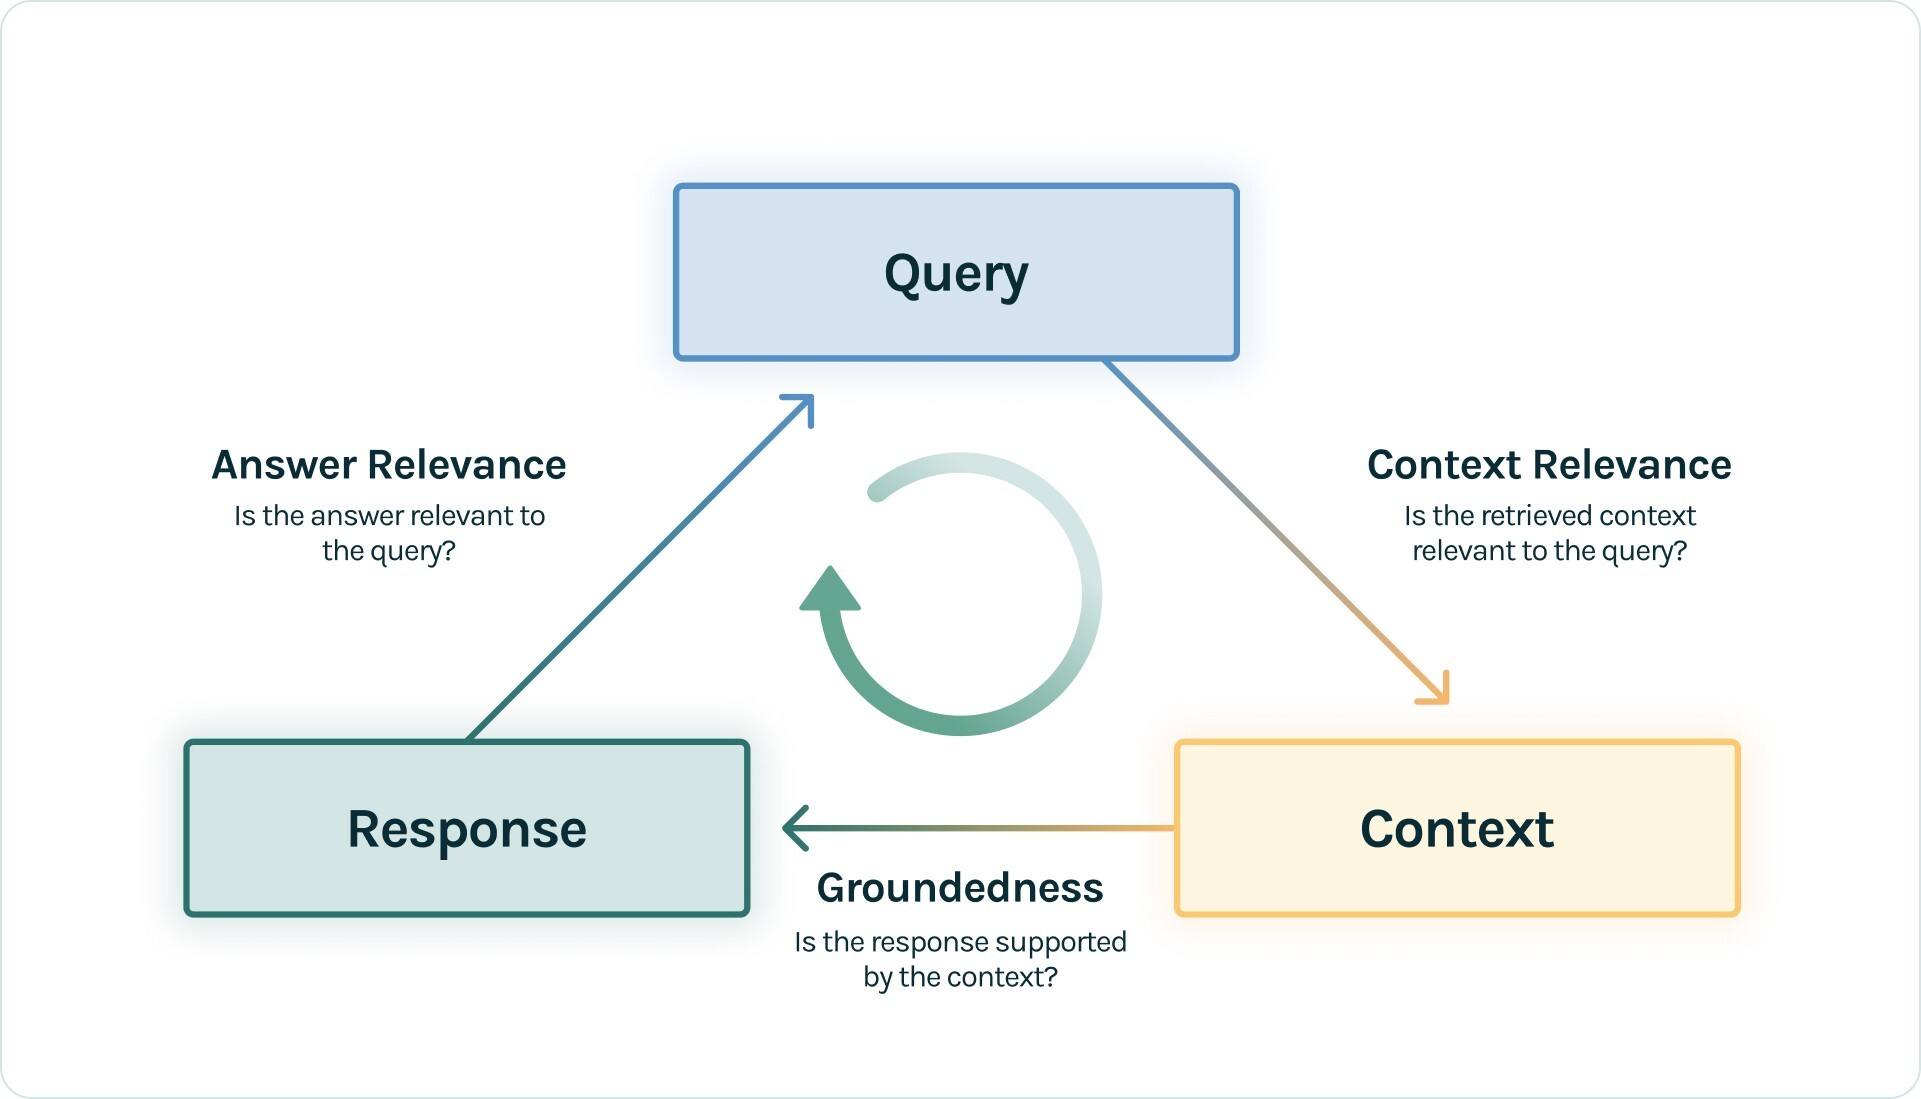

In [116]:
Image(filename='/Users/zsk4gm/Desktop/RAG_Triad.jpg', width=800, height=600)

In [143]:
import trulens_eval
# Imports main tools:
from trulens_eval import TruChain, Tru
tru = Tru()
tru.reset_database()

In [107]:
# Initialize LiteLLM-based feedback function collection class:
from langchain.llms import Ollama
from trulens_eval import LiteLLM
import litellm

In [108]:
#'http://localhost:11435' refers to everyone's local device
ollama_provider = LiteLLM(model_engine='ollama/llama3', api_base='http://174.20.175.133:11435')

Ignoring additional kwargs for singleton endpoint litellm: {'api_base': 'http://174.20.175.133:11435'}
Singleton instance of type LiteLLMEndpoint already created at:
/var/folders/rv/jjx4y3wx623f6kql6mrbtrfw0000gp/T/ipykernel_2327/1555600018.py:2
	ollama_provider = LiteLLM(model_engine='ollama/llama3', api_base='http://174.20.175.133:11435')

You can delete the singleton by calling `<instance>.delete_singleton()` or 
  ```python
  from trulens_eval.utils.python import SingletonPerName
  SingletonPerName.delete_singleton_by_name(name="litellm", cls=LiteLLMEndpoint)
  ```
            


In [159]:
import numpy as np
from trulens_eval import Feedback, Select

context = result['context']
context_texts = [doc.page_content for doc in context]

# Define a groundedness feedback function
f_groundedness = (
    Feedback(ollama_provider.groundedness_measure_with_cot_reasons, name="Groundedness")
    .on(Select.RecordCalls.args.context)  # This selects the context from the function call
    .on_output()
)

# Question/answer relevance between overall question and answer
f_answer_relevance = (
    Feedback(ollama_provider.relevance_with_cot_reasons, name="Answer Relevance")
    .on(Select.RecordCalls.args.query)  # This selects the query/input
    .on_output()  # This selects the output directly
)

# Context relevance between question and each context chunk
f_context_relevance = (
    Feedback(ollama_provider.context_relevance_with_cot_reasons, name="Context Relevance")
    .on(Select.RecordCalls.args.query)  # This selects the query/input
    .on(Select.RecordCalls.args.context)  # This selects the context
    .aggregate(np.mean)
) 

✅ In Groundedness, input source will be set to __record__.app.args.context .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Answer Relevance, input prompt will be set to __record__.app.args.query .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.app.args.query .
✅ In Context Relevance, input context will be set to __record__.app.args.context .


In [160]:
tru_recorder = TruChain(
    app=llm,
    app_id='Chain1_ChatApplication',
    feedbacks=[f_answer_relevance, f_context_relevance, f_groundedness], 
    selectors_check_warning=True
)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                              Selector check failed                                              ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Source of argument prompt to Answer Relevance does not exist in app or expected record:                            

                                                                                                                   
 __record__.app.args.query                                                                                         
 # or equivalently                                                                                                 
 Select.RecordCalls.args.query                                                                                     
                                                                                                                   

The data used to make this check may be incomplete. If you expect records produced by your app to contain the      
selected content, you can ignore this error by setting selectors_nocheck in the TruChain constructor.              
Alternatively, setting selectors_check_warning will print out this message but will not raise an error.            


                                              Additional information:                                              

Feedback function signature:                                                                                       

                                                                                                                   
 (prompt: str, response: str) -> Tuple[float, Dict]                                                                
                                                                                                                   

The prefix __record__.app selects this data that exists in your app or typical records:                            

 • Object of type dict starting with:                                                                              

                                                                                                                   
       {                                                                                                           
         'invoke': [RecordAppCall(...), RecordAppCall(...)],                                                       
         'ainvoke': [RecordAppCall(...), RecordAppCall(...)]                                                       
       }                                                                                                           
                                                                                                                   

ValueError: Some selectors do not exist in the app or record.

In [156]:
with tru_recorder as recording:
    llm_response = chain_plain.invoke({"input": query})

display(llm_response)

NameError: name 'tru_recorder' is not defined

In [78]:
result

{'input': 'Can someone with a conviction get their CDL license?',
 'context': [],
 'answer': 'I\'ve reviewed the provided sections of Virginia law code, and according to § 18.2-246.1 of the Code of Virginia, "Conviction of certain crimes involving commercial motor vehicles" states that:\n\n"...no person who has been convicted of a violation of subsection A or B of § 46.2-341.4 shall be eligible to operate a commercial motor vehicle until five years have elapsed since the date of such conviction."\n\nThis seems relevant to your question about obtaining a CDL license with a conviction.\n\nHowever, it\'s essential to note that Virginia Code § 18.2-246.1 also requires that the person has not been convicted of any other violation related to commercial motor vehicles during the five-year period preceding the application for a CDL.\n\nAccordingly, it appears that having a conviction may impact your eligibility for obtaining a CDL license in Virginia, but I recommend consulting with the Virgin